## 1.0 Importing libraries & Reading in Datasets

In [43]:
# import libraries for data manipulation
import pandas as pd
import re
import statistics
from math import radians, sin, cos, sqrt, atan2

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import libraries for accessing OneMap API
import urllib.parse
import urllib.request
import json
import requests
from tqdm import tqdm
import time

# for model training
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

We are given 5 datasets from 1990 to 2020 and our task is to build a predictive algorithm to determine the 
factors affecting prices of residential properties in Singapore, along with providing insights to detail one or more strategies in curbing housing prices inflation. We would want to <b>use the more recent data which reflects current housing demand-supply patterns, buyer behaviors, and government interventions</b> in order to generate more relevant actionable insights. <b>As such, our analysis will focus mainly on 2015 to 2020 datasets.</b>


In [2]:
# read in the datasets
resale_1 = pd.read_csv('./resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
resale_2 = pd.read_csv('./resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

## 2.0 - Exploratory Data Analysis
We check:
1. number of rows & columns 
2. column names consistency
3. missing values
4. return first 5 rows for observations

Note that we <b>assume duplicated rows were unique transactions.</b>

In [3]:
# function to return shape, column names, and check for missing values
def basic_eda(data):
    # get the rows & columns of data
    rows, cols = data.shape
    print(f"The data has {rows} rows and {cols} columns.\n")
    
    # extract the column names
    column_names = ', '.join([f'"{col}"' for col in data.columns])
    print(f"The column names are: {column_names}.\n")
    
    # check for missing values using isnull() and sum() function
    missing_values = data.isnull().sum()
    print("Number of missing values per column:\n")
    print(missing_values)
    
    # return first 5 rows of data for quick observations
    return data.head()

In [4]:
basic_eda(resale_1)

The data has 37153 rows and 11 columns.

The column names are: "month", "town", "flat_type", "block", "street_name", "storey_range", "floor_area_sqm", "flat_model", "lease_commence_date", "remaining_lease", "resale_price".

Number of missing values per column:

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [5]:
basic_eda(resale_2)

The data has 80374 rows and 11 columns.

The column names are: "month", "town", "flat_type", "block", "street_name", "storey_range", "floor_area_sqm", "flat_model", "lease_commence_date", "remaining_lease", "resale_price".

Number of missing values per column:

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


We noted that `remaining_lease` for 2017 to 2020 is in years and months, whereas for 2015 to 2016, it was only in years. As we are not able to infer the exact years and months for the data prior to 2017, we will store `remaining_lease` in just years.

In [6]:
# function to extract years from remaining lease
def extract_years(lease_str):
    # extract years using regex
    years = re.search(r"(\d+) years", lease_str)
    # store years and months in int, and input 0 if there were none found in regex
    years = int(years.group(1)) if years else 0
    # return the total years
    return years

# apply extract_years to the 'remaining_lease' column in resale_17_to_25
resale_2['remaining_lease_temp'] = resale_2['remaining_lease'].apply(extract_years)
# check if all is right
print(resale_2[['remaining_lease', 'remaining_lease_temp']].head())

      remaining_lease  remaining_lease_temp
0  61 years 04 months                    61
1  60 years 07 months                    60
2  62 years 05 months                    62
3   62 years 01 month                    62
4  62 years 05 months                    62


In [7]:
# drop the 'remaining_lease' column
resale_2 = resale_2.drop(columns = ['remaining_lease'])

# rename the 'remaining_lease_temp' column to 'remaining_lease'
resale_2 = resale_2.rename(columns = {'remaining_lease_temp': 'remaining_lease'})
resale_2.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,61
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,250000.0,60
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,262000.0,62
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,265000.0,62
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,265000.0,62


We can then combine the two datasets into one.

In [8]:
# combine all 2 datasets into one
overall_df = pd.concat([resale_1, resale_2], ignore_index = True)
overall_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [9]:
# get concise summary of the DataFrame
overall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117527 entries, 0 to 117526
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                117527 non-null  object 
 1   town                 117527 non-null  object 
 2   flat_type            117527 non-null  object 
 3   block                117527 non-null  object 
 4   street_name          117527 non-null  object 
 5   storey_range         117527 non-null  object 
 6   floor_area_sqm       117527 non-null  float64
 7   flat_model           117527 non-null  object 
 8   lease_commence_date  117527 non-null  int64  
 9   remaining_lease      117527 non-null  int64  
 10  resale_price         117527 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.9+ MB


The dataset consists of 4 numerical data columns (`floor_area_sqm`, `lease_commence_date`, `resale_price`, `remaining_lease`) and 7 categorical data columns (`month`, `town`, `flat_type`, `block`, `street_name`, `storey_range`, `flat_model`]

### 2.1 - Numerical Data Exploration
We perform some EDA on the 4 numerical data columns.

In [10]:
# check the statistical summary of the 4 numerical columns using describe() function
overall_df.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price
count,117527.000000,117527.000000,117527.000000,1.175270e+05
mean,97.428947,1993.106758,74.137117,4.385408e+05
std,24.259687,12.338690,12.238072,1.480609e+05
min,31.000000,1966.000000,45.000000,1.400000e+05
25%,77.000000,1984.000000,65.000000,3.330000e+05
50%,95.000000,1993.000000,73.000000,4.088880e+05
75%,112.000000,2002.000000,83.000000,5.080000e+05
max,280.000000,2019.000000,97.000000,1.258000e+06


The smallest unit is 31 sqm while the biggest is 280.0 sqm. Median size is 95.0 sqm.<br>
The lease commence date started from 1966 to 2019, with median of 1993.<br>
The remaining lease ranges from 45 years to 97 years, with median around 73 years. <br>
The resale price ranges from 140,000 to 1,258,000, with the median price of 408,000.

Note that in Singapore's context, there is a minimum occupancy period (MOP) of 5 years<sup>[1]</sup> before one can sell their HDB unless there are exceptional circumstances. From the statistics above, there were records with 97 years `remaining_lease` in the dataset which we should remove.

In [11]:
# display the records with remaining_lease above 95
overall_df.loc[overall_df.remaining_lease > 95, :]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
571,2015-01,JURONG WEST,3 ROOM,339A,KANG CHING RD,04 TO 06,67.0,Model A,2012,96,330000.0
689,2015-01,KALLANG/WHAMPOA,4 ROOM,38D,BENDEMEER RD,10 TO 12,92.0,Model A,2012,96,650000.0
690,2015-01,KALLANG/WHAMPOA,4 ROOM,5A,UPP BOON KENG RD,25 TO 27,93.0,Model A,2012,96,675000.0
823,2015-01,QUEENSTOWN,4 ROOM,28B,DOVER CRES,16 TO 18,88.0,Model A,2012,96,668000.0
826,2015-01,QUEENSTOWN,4 ROOM,18C,HOLLAND DR,01 TO 03,92.0,Model A,2012,96,728000.0
...,...,...,...,...,...,...,...,...,...,...,...
78084,2018-12,BUKIT MERAH,5 ROOM,9A,BOON TIONG RD,37 TO 39,112.0,Improved,2016,96,1150000.0
79521,2019-01,BUKIT MERAH,5 ROOM,9B,BOON TIONG RD,28 TO 30,112.0,Improved,2016,96,970000.0
110907,2020-07,CLEMENTI,5 ROOM,440C,CLEMENTI AVE 3,31 TO 33,112.0,Improved,2018,97,957888.0
112968,2020-08,BUKIT MERAH,3 ROOM,96A,HENDERSON RD,10 TO 12,68.0,Model A,2019,97,612000.0


In [12]:
# remove the 156 records from the dataset
overall_df = overall_df.loc[overall_df.remaining_lease <= 95, :]
overall_df.reset_index(drop = True, inplace = True)

array([[<Axes: title={'center': 'floor_area_sqm'}>,
        <Axes: title={'center': 'lease_commence_date'}>,
        <Axes: title={'center': 'remaining_lease'}>,
        <Axes: title={'center': 'resale_price'}>]], dtype=object)

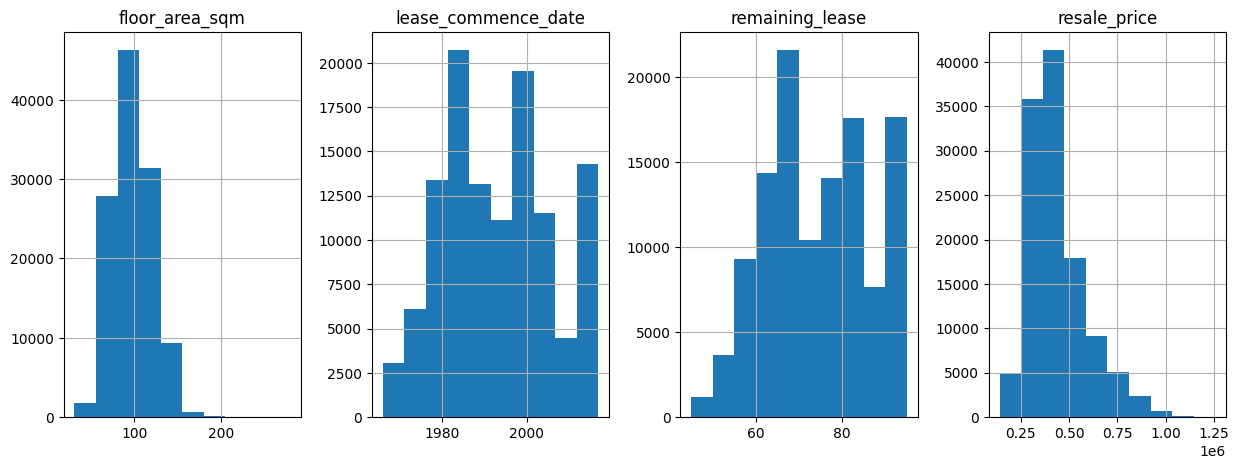

In [13]:
# plot the histogram for the 4 numerical data columns
overall_df.hist(figsize = (15, 5), layout = (1, 4))

For floor area, majority of the flats lie between 77 to 112 sqm.<br>
There was a spike in resale flats for lease that started in 1984 and 2002.<br>
Flats with less number of remaining lease years tend to not fall into resale transactions.<br>

### 2.2 - Categorical Data Exploration
We perform some EDA on the 4 out of the 7 categorical data columns, mainly `town`, `flat_type`, `storey_range`, `flat_model`

In [14]:
# creating categorical columns
cat_cols = ['town', 'flat_type', 'storey_range', 'flat_model']

# analyse the % sub categories of each category
for i in cat_cols:
    print(overall_df[i].value_counts(normalize = True))
    print('*'*40)

town
SENGKANG           0.076723
JURONG WEST        0.075564
WOODLANDS          0.073425
TAMPINES           0.067316
YISHUN             0.066388
BEDOK              0.057919
PUNGGOL            0.056820
HOUGANG            0.049050
ANG MO KIO         0.046468
CHOA CHU KANG      0.043478
BUKIT PANJANG      0.039149
BUKIT BATOK        0.037948
BUKIT MERAH        0.037735
TOA PAYOH          0.031873
PASIR RIS          0.030723
KALLANG/WHAMPOA    0.029045
SEMBAWANG          0.026565
QUEENSTOWN         0.026054
GEYLANG            0.025219
CLEMENTI           0.023055
JURONG EAST        0.022288
SERANGOON          0.020678
BISHAN             0.018914
CENTRAL AREA       0.009099
MARINE PARADE      0.005879
BUKIT TIMAH        0.002624
Name: proportion, dtype: float64
****************************************
flat_type
4 ROOM              0.412282
3 ROOM              0.250513
5 ROOM              0.244072
EXECUTIVE           0.078818
2 ROOM              0.013521
1 ROOM              0.000435
MULTI-GEN

- <b>Seng Kang, Jurong West, and Woodlands</b> had the most no. of resale transactions, while central region like <b>Central Area, Marine Parade, and Bukit Timah</b> had the least. <br>
- <b>4 room</b> flat type was the most common for resale, while <b>Multi-Generation</b> was the least common. <br>
- <b>01-12</b> floors were most common storey range of resale flats, and those on the higher floors <b>13-51</b> had lesser.<br>
- <b>Model A</b> flat type was the most common of resale flats, and <b>Improved-Maisonette, Premium Maisonette, 2-room</b> had least.<br>

We can also plot the frequency of `remaining_lease`.

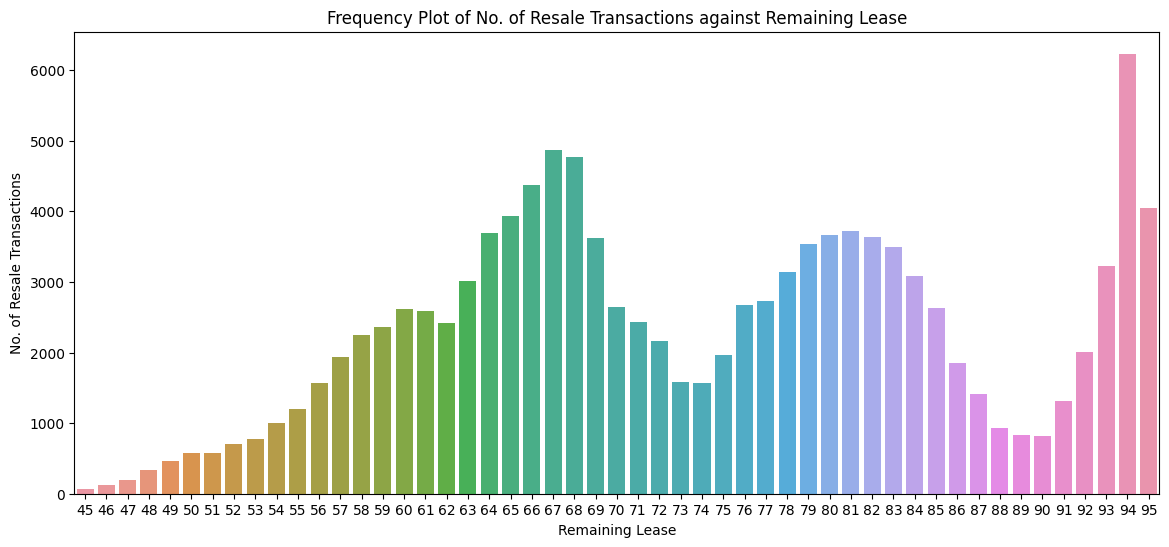

In [15]:
# plot frequency plot of remaining_lease
plt.figure(figsize=(14, 6))
sns.countplot(data = overall_df, x = 'remaining_lease')
plt.title('Frequency Plot of No. of Resale Transactions against Remaining Lease')
plt.xlabel('Remaining Lease')
plt.ylabel('No. of Resale Transactions')
plt.show()

As expected, there were high no. of transactions upon reaching MOP at 94/95 remaining lease years.

## 3.0 - Bivariate and Multivariate analysis
In this section, we explore possible relationship between the variables against `resale_price`.<br>
We first check the `resale_price` trend over time on `month`, as well as `lease_commence_date`. As the `month` column was in year and month format, we will transform it to just years.

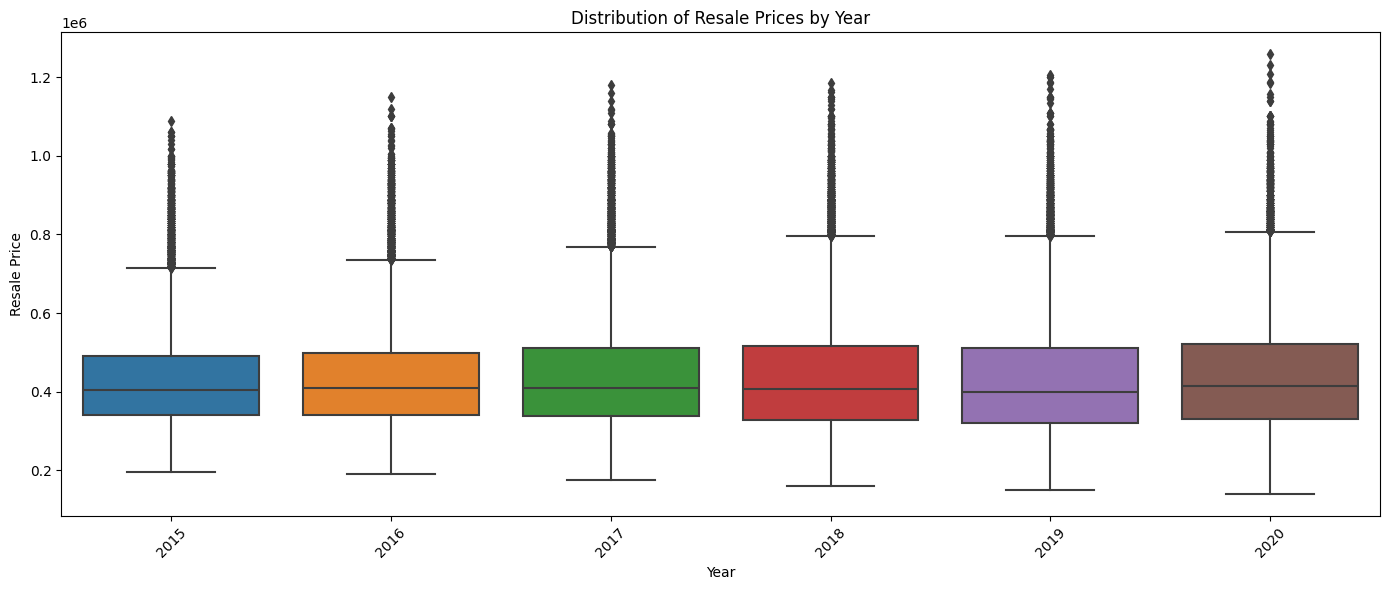

In [16]:
# change the 'month' column to datetime format
overall_df['month'] = pd.to_datetime(overall_df['month'])
# create a new column transaction year from month
overall_df['transaction_year'] = overall_df['month'].dt.year

#  plot boxplot for resale_price by transaction year
plt.figure(figsize=(14, 6))
sns.boxplot(x='transaction_year', y='resale_price', data=overall_df)

plt.title('Distribution of Resale Prices by Year')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

We observe that the resale prices were generally consistent throughout 2015 to 2020.

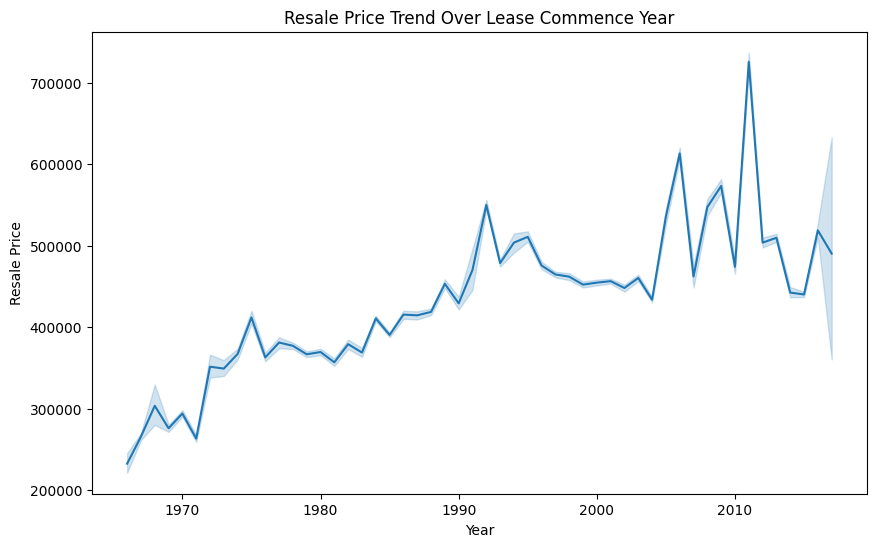

In [17]:
# plot lease commence date against resale price
plt.figure(figsize = (10, 6))
sns.lineplot(x = 'lease_commence_date', y = 'resale_price', data = overall_df)
plt.title('Resale Price Trend Over Lease Commence Year')
plt.xlabel('Year')
plt.ylabel('Resale Price')
plt.show()

The general trend is the later the commencement of the flat (i.e. the younger the flat), the higher the price of the resale flat.

Next, we explore `flat_type` and `floor_area_sqm` against `resale_price`. Usually the larger the flat, the more pricier the price of the HDB.

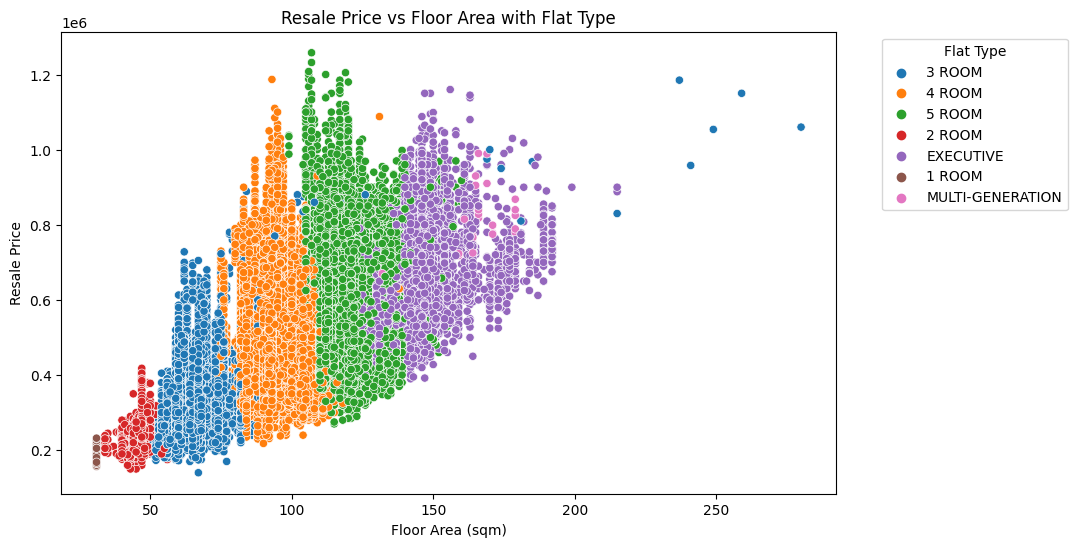

In [18]:
# plot floor area sqm against resale price
plt.figure(figsize = (10, 6))
sns.scatterplot(x = 'floor_area_sqm', y = 'resale_price', hue = 'flat_type', data = overall_df)
plt.title('Resale Price vs Floor Area with Flat Type')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.legend(title = 'Flat Type', bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.show()

Indeed, the larger the `floor_area_sqm` and `flat_type`, the pricier the flat. But also note that there were a few `flat_type` of 3 room with large `floor_area_sqm` and fetching higher resale price than majority of the 3 room flats.

We can explore the resale price over different `town`.

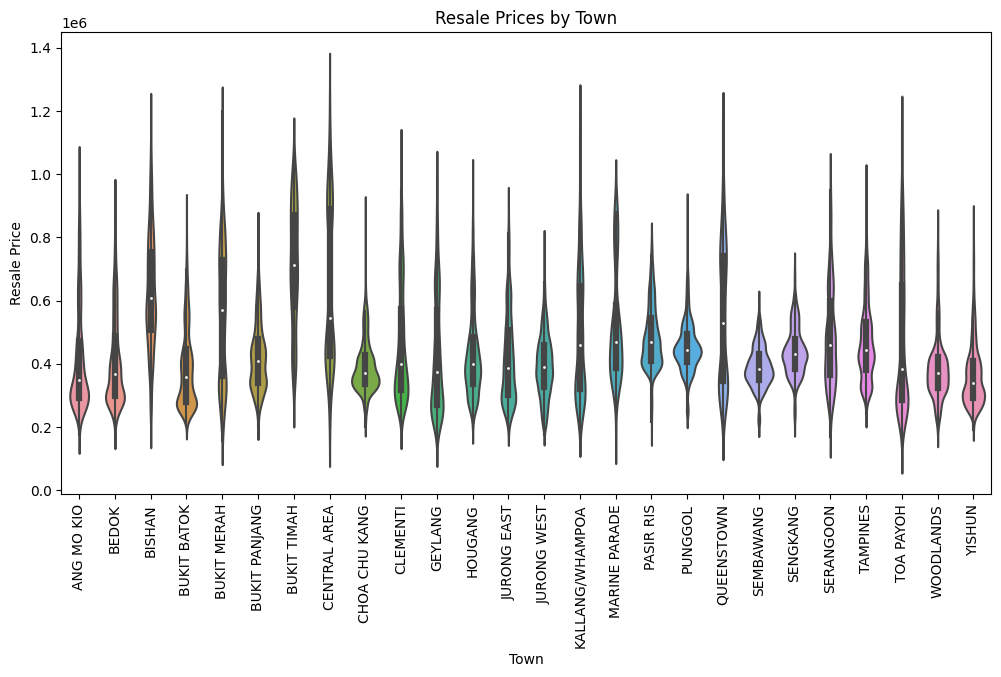

In [19]:
plt.figure(figsize = (12, 6))
sns.violinplot(x = 'town', y = 'resale_price', data = overall_df)
plt.title('Resale Prices by Town')
plt.xlabel('Town')
plt.ylabel('Resale Price')
plt.xticks(rotation = 90)
plt.show()

Higher-end areas like <b>Central Area and Bukit Timah</b> had a broader range of higher prices, while others like <b>Woodlands, Yishun, Choa Chu Kang, Sembawang</b> are more concentrated in the lower price range.

## 4.0 - Data Pre-Processing
Before we perform any modelling, we can consider other data sources that can be useful in determining the price of a HDB resale flat such as proximity to nearest amenities like CBD (i.e. Raffles Place MRT), MRT stations, hospitals, schools, or shopping malls. We are provided with the block number and street name which we can obtain the latitude and longitude.

As the number of transactions here is relatively big, we can obtain the latitude and longitude more efficiently by removing duplicated block as there will be multiple units transacted within the same HDB Apartment Block.

In [20]:
# Lcombine the block and street name to form the address of unit
overall_df['address'] = overall_df['block'] + ' ' + overall_df['street_name'] + ' '+ 'SINGAPORE'

# get unique address list
resale_temp = overall_df.drop_duplicates(subset = 'address', keep = 'first')
address_list = resale_temp['address'].tolist()
len(address_list)

8958

We will obtain the latitude and longitude through OneMap API but note that this will take awhile to run.

In [97]:
# empty list to store result
results = []
# loop through each address
for each in tqdm(address_list, desc = 'Extracting information'):
    url = f'https://www.onemap.gov.sg/api/common/elastic/search?searchVal={each}&returnGeom=Y&getAddrDetails=Y&pageNum=1'
    # exception to handle api timeout
    try:
        response = requests.get(url, timeout=10)
        data = response.json()
        # if there is results, extract the latitude and longitude
        if data.get('results'):
            result = data['results'][0]
            results.append({
                'address': each,
                'Latitude': float(result['LATITUDE']),
                'Longitude': float(result['LONGITUDE']),
                'PostalCode': result.get('POSTAL', None)
            })
        # if no results, we append none
        else:
            results.append({'address': each, 'Latitude': None, 'Longitude': None, 'PostalCode': None})
    # if api timeout, we run the
    except Exception as e:
        print(f"Failed for address: {each}, error: {e}")
        results.append({'address': each, 'Latitude': None, 'Longitude': None})
    # to rest the api
    time.sleep(0.1)

# convert to DataFrame
df_coordinates = pd.DataFrame(results)

Extracting information:  13%|██████▉                                             | 1193/8958 [22:39<2:21:47,  1.10s/it]

Failed for address: 3 BEDOK STH AVE 1 SINGAPORE, error: Expecting value: line 1 column 1 (char 0)


Extracting information: 100%|████████████████████████████████████████████████████| 8958/8958 [2:53:05<00:00,  1.16s/it]


In [203]:
# manual run of api call for the error address
url = f'https://www.onemap.gov.sg/api/common/elastic/search?searchVal=3 BEDOK STH AVE 1 SINGAPORE&returnGeom=Y&getAddrDetails=Y&pageNum=1'
response = requests.get(url, timeout=10)
data = response.json()
data.get('results')

[{'SEARCHVAL': '3 BEDOK SOUTH AVENUE 1 SINGAPORE 460003',
  'BLK_NO': '3',
  'ROAD_NAME': 'BEDOK SOUTH AVENUE 1',
  'BUILDING': 'NIL',
  'ADDRESS': '3 BEDOK SOUTH AVENUE 1 SINGAPORE 460003',
  'POSTAL': '460003',
  'X': '39113.6853058571',
  'Y': '33796.4224030245',
  'LATITUDE': '1.32191533930821',
  'LONGITUDE': '103.933180861675'},
 {'SEARCHVAL': 'BEDOK COURT',
  'BLK_NO': '299',
  'ROAD_NAME': 'BEDOK SOUTH AVENUE 3',
  'BUILDING': 'BEDOK COURT',
  'ADDRESS': '299 BEDOK SOUTH AVENUE 3 BEDOK COURT SINGAPORE 469298',
  'POSTAL': '469298',
  'X': '40392.4424206764',
  'Y': '33760.6842379496',
  'LATITUDE': '1.32159164491009',
  'LONGITUDE': '103.94467113581'},
 {'SEARCHVAL': 'BEDOK COURT',
  'BLK_NO': '297',
  'ROAD_NAME': 'BEDOK SOUTH AVENUE 3',
  'BUILDING': 'BEDOK COURT',
  'ADDRESS': '297 BEDOK SOUTH AVENUE 3 BEDOK COURT SINGAPORE 469297',
  'POSTAL': '469297',
  'X': '40524.5678297151',
  'Y': '33844.2970307264',
  'LATITUDE': '1.32234775413853',
  'LONGITUDE': '103.945858384014'}

In [209]:
# manually input the results
df_coordinates.loc[df_coordinates.address == '3 BEDOK STH AVE 1 SINGAPORE', 'Latitude'] = 1.32191533930821
df_coordinates.loc[df_coordinates.address == '3 BEDOK STH AVE 1 SINGAPORE', 'Longitude'] = 103.933180861675
df_coordinates.loc[df_coordinates.address == '3 BEDOK STH AVE 1 SINGAPORE', 'PostalCode'] = 460003

In [211]:
# output this lat and lon to skip further rerunning as code takes awhile to run
df_coordinates.to_csv('./lat_lon.csv', index = False)

In [21]:
# read in from folder
df_coordinates = pd.read_csv('./lat_lon.csv')

### 4.1 - Distance to CBD
Central Business District is usually the place where most office workers will travel to during weekdays for work. Staying nearer to it will no doubt save on travelling time, and possibly, is one factor that can affect hdb resale prices. In this analysis, we will assume the CBD is <b>Raffles Place MRT</b>, where we will obtain the coordinates from Wikipedia<sup>[2]</sup>.

Once obtained, for each of the hdb coordinates, we will calculate the haversine distance<sup>[3]</sup> to CBD.

In [23]:
# store the raffles place mrt coordinates
raffles = [1.283889, 103.851389]

In [24]:
# haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [25]:
# empty list to store result
dist_to_cbd = []
# loop through each coordinate
for i in range(0, len(df_coordinates)):
    # get the haversine distance to raffles mrt
    dist_to_cbd.append(haversine(df_coordinates.iloc[i, 1], df_coordinates.iloc[i, 2], raffles[0], raffles[1]))
# store in df_coordinates dataframe
df_coordinates['dist_to_cbd'] = dist_to_cbd

### 4.2 - Distance to Nearest Hospital
As Singapore is facing an ageing population, accessibility to healthcare is important. Staying near to a healthcare facilities like polyclinic or public hospital can be a possible reason hdb flat buyers look out for, and therefore, is more willing to purchase them at a higher price.

We will extract the coordinates of the polyclinic and government hospitals from gov.sg<sup>[4]</sup>.

In [26]:
# extract coordinates of public hospitals and polyclinics
healthcare = {'AH': [1.2866, 103.8013],
             'CGH': [1.3402, 103.9496],
             'KTPH': [1.424635, 103.838208],
             'KKH': [1.3106, 103.8468],
             'NUH': [1.2937, 103.7831],
             'NTFGH': [1.335, 103.7439],
             'SGH': [1.2804, 103.8348],
             'TTSH': [1.3214, 103.8458],
             'Ang Mo Kio Poly': [1.373820, 103.846611],
             'Geylang Poly': [1.319060, 103.887093],
             'Hougang Poly': [1.368530, 103.890381],
             'Kallang Poly': [1.289440, 103.849983],
             'Khatib Poly': [1.429725, 103.835907],
             'Sembawang Poly': [1.44684,103.82344],
             'Toa Payoh Poly': [1.33450,103.85899],
             'Woodlands Poly': [1.43079,103.77523],
             'Yishun Poly': [1.43166,103.83987],
             'Bukit Batok Poly': [1.35200,103.74774],
             'Bukit Panjang Poly': [1.38266,103.76008],
             'CCK Poly': [1.38237,103.75077],
             'Clementi Poly': [1.31275,103.76580],
             'Jurong Poly': [1.34974,103.73072],
             'Pioneer Poly': [1.33854,103.69886],
             'Queenstown Poly': [1.29846,103.80108],
             'Bedok Poly': [1.32687,103.93190],
             'Bukit Merah Poly': [1.28367,103.81637],
             'Eunos Poly': [1.31733,103.90571],
             'Marine Parade Poly': [1.30225,103.90789],
             'Outram Poly': [1.27992,103.83773],
             'Pasir Ris Poly': [1.33759,103.83647],
             'Punggol Poly': [1.40282,103.91318],
             'Sengkang Poly': [1.39261,103.89435],
             'Tampines Poly': [1.35698,103.94584]}

In [27]:
# function to get the nearest healthcare distance
def nearest_healthcare(lat, lon):
    # empty list to store result
    distance = []
    # loop through each healthcare facility and calculate haversine distance to this house
    for name, coords in healthcare.items():
        distance.append(haversine(lat, lon, coords[0], coords[1]))
    # return the shortest distance
    nearest = min(distance)  # Corrected this line
    return nearest

# apply function to each row
df_coordinates['nearest_healthcare_dist'] = df_coordinates.apply(lambda row: nearest_healthcare(row['Latitude'], row['Longitude']), axis=1)

### 4.3 - Distance to Nearest Shopping Mall
Staying near shopping mall is definitely a convenient thing for most HDB owners as they can easily do their groceries, run their clinics, or even dine at restaurants. As such, this might be one potential factor that determine the resale price of a HDB. We get the coordinates of shopping malls in Singapore from Kaggle<sup>[5]</sup> that was obtained through web scraping and their coordinates were gathered using OneMap API.

In [28]:
# read in downloaded shopping mall dataset
shopping = pd.read_csv('./shopping_mall_coordinates.csv')

In [29]:
# function to get the nearest shopping mall distance
def nearest_shopping(lat, lon):
    # run haversine function on the coordinates for this house and the malls
    distances = shopping.apply(lambda row: haversine(lat, lon, row['LATITUDE'], row['LONGITUDE']), axis=1)
    nearest = distances.min()
    return nearest

# apply function to each row in df_coordinates
df_coordinates['nearest_shopping_dist'] = df_coordinates.apply(lambda row: nearest_shopping(row['Latitude'], row['Longitude']), axis=1)

### 4.4 - Merging Dataframes & Dropping Columns
We can then merge `df_coordinates` to `overall_df`.

Also, we can drop columns that are not useful in our resale price prediction:
1. `month` - not useful in resale price prediction
2. `block` - not useful in resale price prediction
3. `street_name` - not useful in resale price prediction
4. `lease_commence_date` - duplicated variable with `remaining_lease`
5. `transaction_year` - not useful in resale price prediction
6. `address` - not useful in resale price prediction
7. `Latitude` - not useful in resale price prediction
8. `Longitude` - not useful in resale price prediction
9. `PostalCode` - not useful in resale price prediction

In [30]:
# merge overall_df and df_coordinates together on address
overall_df = pd.merge(overall_df, df_coordinates, on = 'address', how = 'left')
# drop the unnecessary columns 
overall_df = overall_df.drop(columns = ['month', 'block', 'street_name', 'lease_commence_date', 'transaction_year',\
                                        'address', 'Latitude', 'Longitude', 'PostalCode'])
overall_df.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,resale_price,dist_to_cbd,nearest_healthcare_dist,nearest_shopping_dist
0,ANG MO KIO,3 ROOM,07 TO 09,60.0,Improved,70,255000.0,10.256788,1.009624,0.990470
1,ANG MO KIO,3 ROOM,01 TO 03,68.0,New Generation,65,275000.0,10.022306,1.001684,0.897301
2,ANG MO KIO,3 ROOM,01 TO 03,69.0,New Generation,64,285000.0,10.077297,0.938093,0.882446
3,ANG MO KIO,3 ROOM,01 TO 03,68.0,New Generation,63,290000.0,9.336562,1.182872,0.784063
4,ANG MO KIO,3 ROOM,07 TO 09,68.0,New Generation,64,290000.0,9.781358,1.260540,1.063883


With that, we are left with 9 feature variables and 1 target variable (i.e. `resale_price`).

### 4.5 - Handling `Storey_Range`
Since `storey_range` is categorical currently (e.g. 10 to 12), we will extract the median from it to get a meaningful numerical representation for this column.

In [31]:
# function to split data with `TO` and get the median between the first and second number
def get_median(x):
    split_list = x.split(' TO ')
    float_list = [float(i) for i in split_list]
    median = statistics.median(float_list)
    return median

# create a storey_median column by applying get_median function to storey_range column
overall_df['storey_median'] = overall_df['storey_range'].apply(lambda x: get_median(x))

# drop the 'storey_range' column
overall_df = overall_df.drop(columns = ['storey_range'])
# print out the resale df
overall_df.head()

,town,flat_type,floor_area_sqm,flat_model,remaining_lease,resale_price,dist_to_cbd,nearest_healthcare_dist,nearest_shopping_dist,storey_median
0,ANG MO KIO,3 ROOM,60.0,Improved,70,255000.0,10.256788,1.009624,0.990470,8.0
1,ANG MO KIO,3 ROOM,68.0,New Generation,65,275000.0,10.022306,1.001684,0.897301,2.0
2,ANG MO KIO,3 ROOM,69.0,New Generation,64,285000.0,10.077297,0.938093,0.882446,2.0
3,ANG MO KIO,3 ROOM,68.0,New Generation,63,290000.0,9.336562,1.182872,0.784063,2.0
4,ANG MO KIO,3 ROOM,68.0,New Generation,64,290000.0,9.781358,1.260540,1.063883,8.0


### 4.6 - Handling `Town`, `Flat_Model` and `Flat_Type`
Both `town` and `flat_model` are categorical variables in which regression model cannot handle well. Furthermore, both of these variables have no set order between them (i.e. not ordinal), and therefore, we can transform them using one-hot encoding.

For `flat_type`, it is also categorical in which we have to change into numerical representation. However, this variable has a certain order to it where <b>1 ROOM</b> is the smallest, and <b>MULTI GENERATION</b> is the biggest. As there is a meaningful order, we will transformed this variable using an ordinal encoding ranging from 1 to 7.

In [32]:
# make a copy of the overall_df before encoding
overall_df_sub = overall_df.copy()

In [33]:
# build a pipeline to perform encoding
pipeline = ColumnTransformer([ 
     ('o', OrdinalEncoder(), ['flat_type']), 
     ('n', OneHotEncoder(sparse_output = False, drop = 'first'), ['town', 'flat_model']), 
     ], 
     remainder = 'passthrough', verbose_feature_names_out = False
)
# transformation outputs a Pandas DataFrame
pipeline.set_output(transform = "pandas")
overall_df_sub = pipeline.fit_transform(overall_df_sub)

In [34]:
overall_df_sub.head()

,flat_type,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,town_CENTRAL AREA,town_CHOA CHU KANG,town_CLEMENTI,...,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,floor_area_sqm,remaining_lease,resale_price,dist_to_cbd,nearest_healthcare_dist,nearest_shopping_dist,storey_median
0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,60.0,70,255000.0,10.256788,1.009624,0.990470,8.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,68.0,65,275000.0,10.022306,1.001684,0.897301,2.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,69.0,64,285000.0,10.077297,0.938093,0.882446,2.0
3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,68.0,63,290000.0,9.336562,1.182872,0.784063,2.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,68.0,64,290000.0,9.781358,1.260540,1.063883,8.0


## 5.0 - Model Development
In this section, we will build ML models to predict the `resale_price` and identify variables that are of higher importance in determining the `resale_price`. The first model that we will build is <b>Multiple Linear Regression</b> as it is a simple model that shows direct relationships between the target variable (i.e. `resale_price`) and the predictors. By inspecting the regression coefficients, we can gauge how each feature impacts the `resale_price`.

### 5.1 - Model 1: Multiple Linear Regression
First, we will perform train-test split on the dataset so that we can validate the performance of our model which was trained on 80% of the dataset, and tested on 20% of the dataset.

Once the model is built, we will evaluate the model using <b>Mean-Square Error</b> which measures the average of the squared differences between the actual and predicted values, indicating how close the predictions are to the real data (lower values are better), and <b>R<sup>2</sup> score</b> which represents the proportion of the variance in the target variable that is explained by the features in the model, with a value closer to 1 indicating a better fit.

In [35]:
# store the feature variables as X, target variable as y
X = overall_df_sub.drop('resale_price', axis = 1)
y = overall_df_sub['resale_price']

# perform train test split using 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# create and train the linear regression model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# make predictions
y_pred = lm_model.predict(X_test)

# evaluate the model use mse and r2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2750544647.274563
R-squared: 0.8736299554549618


The R<sup>2</sup> score is 0.8736 which is quite decent.

We can check the coefficients of each of the feature variables and determine the importance of them. They can either be positive which indicate positive relationship between itself and target variable (e.g. the higher it is, the higher the resale price) or negative which is the other direction (e.g. the higher it is, the lower the resale price). We can also determine the importance of the variables based on the magnitude (e.g. the larger the coefficient, the more impact in the increase/decrease of the resale price depending on the direction).

In [36]:
# check coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lm_model.coef_})
coefficients = coefficients.sort_values(by = 'Coefficient', ascending = False)
coefficients

,Feature,Coefficient
42,flat_model_Terrace,330213.484473
6,town_BUKIT TIMAH,240720.136312
44,flat_model_Type S2,198134.167596
30,flat_model_Improved-Maisonette,174203.444412
28,flat_model_DBSS,136447.402058
43,flat_model_Type S1,132854.392173
38,flat_model_Premium Apartment Loft,122834.320721
15,town_MARINE PARADE,118063.671511
33,flat_model_Model A-Maisonette,116480.652882
35,flat_model_Multi Generation,111556.104004


Based on the coefficients:
- `flat_model` is a good predictor for `resale_price`, especially for `flat_model_Terrace` which will increase the resale price by SGD 330213.48.
- As seen during our EDA, `town_BUKIT TIMAH`, `town_MARINE PARADE`, `town_QUEENSTOWN` which are in the central region fetches higher resale price. A HDB in Bukit Timah increase the resale price by SGD 240720.14.
- For `dist_to_cbd`, 1km the flat is further away from the CBD, the resale price will drop by SGD 11323.45 and this support our hypothesis that people would want to stay near CBD area.
- Interestingly, the other variables that we added `nearest_healthcare_dist` and `nearest_shopping_dist` had negative impact to the resale price. Being nearer to either seems to decrease the resale price, which contradicts our hypothesis that people would want to stay near them.

### 5.2 - Model 1*: Multiple Linear Regression
We can aim to improve on our R<sup>2</sup> score by performing feature selection whereby we can first remove variables that are statistically insignificant based on their p-value (i.e. above 0.05 based on a 95% confidence interval).

In [37]:
# train model using sm package to get p-values
## add constant for intercept
X_train_sm = sm.add_constant(X_train)

# fit OLS model
lm_model_sm = sm.OLS(y_train, X_train_sm).fit()

print(lm_model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 1.262e+04
Date:                Fri, 09 May 2025   Prob (F-statistic):               0.00
Time:                        15:05:26   Log-Likelihood:            -1.1541e+06
No. Observations:               93896   AIC:                         2.308e+06
Df Residuals:                   93844   BIC:                         2.309e+06
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

From the summary, we can remove:
- `town_BEDOK`
- `town_TOA PAYOH`
- `flat_model_Apartment`
- `flat_model_Improved`
- `flat_model_Maisonette`
- `flat_model_Model A`
- `flat_model_Model A2`
- `flat_model_New Generation`
- `flat_model_Premium Apartment`
- `flat_model_Simplified`
- `flat_model_Standard`

In [38]:
# store the feature variables as X, target variable as y
X = overall_df_sub.drop('resale_price', axis = 1)
y = overall_df_sub['resale_price']

# remove variables from X
to_drop = ['town_BEDOK', 'town_TOA PAYOH', 'flat_model_Apartment', 'flat_model_Improved', 'flat_model_Maisonette',\
           'flat_model_Model A', 'flat_model_Model A2', 'flat_model_New Generation', 'flat_model_Premium Apartment',\
           'flat_model_Simplified', 'flat_model_Standard']

X = X.drop(columns = to_drop)
# perform train test split using 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# create and train the linear regression model
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# make predictions
y_pred = lm_model.predict(X_test)

# evaluate the model use mse and r2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 2871122790.12766
R-squared: 0.868090156165173


The R<sup>2</sup> score went down from 0.8736 to 0.8681, and the MSE went up from 2750544647 to 287112279.<br>
Therefore, the first model still performs the best.

### 5.3 - Model 2: Random Forest
The second model we will build is Random Forest. Linear Regression assumes a linear relationship between `resale_price` and the feature variables, and that might not be true. Furthermore, one of the assumptions of Linear Regression is that the feature variables should be independent of each other which might not hold in our dataset (e.g. certain towns might only have certain flat type or flat model). Lastly, Linear Regression is sensitive to outliers as we know there have been a few instances as seen in the scatter plot in Section 3 whereby there were a few flat_type of 3 room with large floor_area_sqm and fetching higher resale price than majority of the 3 room flats.

Therefore, we can explore Random Forest which firstly, do not assume linear relationship. Secondly, can automatically capture interaction relationship between feature variables, and lastly, more robust to outliers.

In [39]:
# store the feature variables as X, target variable as y
X = overall_df_sub.drop('resale_price', axis = 1)
y = overall_df_sub['resale_price']

# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# create and train the random forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# make predictions
y_pred = rf_model.predict(X_test)

# evaluate the model use mse and r2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 654781533.0818979
R-squared: 0.9699169502357224


The R<sup>2</sup> score here is 0.9699 which is a lot higher than our Multiple Linear Regression of 0.8736, which indicates this is a better model. The MSE is also lower at 657854145 than 2750544647.

In Random Forest, we can inspect the feature importances to see which features are the most important in predicting `resale_price`.

In [40]:
# extract the feature importance
importance = rf_model.feature_importances_

# create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)

print(feature_importance_df)

                              Feature  Importance
45                     floor_area_sqm    0.457480
47                        dist_to_cbd    0.302031
46                    remaining_lease    0.081119
0                           flat_type    0.029473
49              nearest_shopping_dist    0.024693
50                      storey_median    0.024474
48            nearest_healthcare_dist    0.022896
28                    flat_model_DBSS    0.015270
32                 flat_model_Model A    0.005514
2                         town_BISHAN    0.002818
9                       town_CLEMENTI    0.002660
22                      town_TAMPINES    0.002654
18                    town_QUEENSTOWN    0.002593
6                    town_BUKIT TIMAH    0.002497
42                 flat_model_Terrace    0.002439
7                   town_CENTRAL AREA    0.002289
11                       town_HOUGANG    0.001866
29                flat_model_Improved    0.001653
1                          town_BEDOK    0.001650


On a contrary to what was being identified in Model 1 as important variables (i.e. `town` and `flat_model`), they were both deemed not as important in this model. The top 3 important features were `floor_area_sqm`, `dist_to_cbd`, and `remaining_lease` which were more logical choices as bigger houses, nearer to CBD and longer remaining lease should fetch higher `resale_price`.

### 5.4 - Model 2*: Random Forest
We shall perform hyperparameter tuning using a GridSearch approach on the following:
- Number of Trees (n_estimators): No. of trees to grow in the forest
- Max Depth (max_depth): Limits how deep each tree can grow
- Minimum Samples to Split (min_samples_split): Controls when a node should be split
- Max Features (max_features): Controls how many features each tree considers


In [48]:
# store the feature variables as X, target variable as y
X = overall_df_sub.drop('resale_price', axis = 1)
y = overall_df_sub['resale_price']

# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [10, 20],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples for splitting
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# initialize the RandomForestRegressor
rf_model = RandomForestRegressor()

# perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv = 5,  # 5-fold cross-validation
    scoring = 'r2',  # Metric to optimize
    verbose = 2 # print details
)

# fit the model on training data 
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   7.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   7.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   7.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  15.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  14.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=  15.9s
[CV] END max_depth=10, max_features=sqrt, m

[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=50; total time=  15.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=50; total time=  15.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=50; total time=  15.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  31.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  32.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  35.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  35.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  34.6s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=50; total time=  19.7s
[CV] END max_depth=20, max_features=log2, min_samples_split=2, n_estimators=50; total time=  19.

Even with fine-tuning of the hyperparameters, it seem that the default Model is better when comparing the R<sup>2</sup> score (0.9699 vs 0.9582).

### 5.5 - Model 3: LightGBM
The last model we will build is LightGBM which is a gradient boosting model that performs well for both regression or classification tasks. Gradient boosting models sequentially train tree by tree and learn the mistakes of current tree before building the next one. Similar to Random Forest, it also capture non-linear relationships and interactions between features but do so more effectively by focusing on reducing errors made by previous trees.

By building LightGBM, we would have compared a simple linear model, a non-linear ensemble model (Random Forest), and a boosting model, which are three of the most commonly used approaches in predictive modelling.

For LightGBM, we do not need to perform one-hot encoding to the categorical variables as we can inform the model which are categorical and it will handle them automatically, and neither do we have to perform normalization of the numerical variables as it is a tree-based algorithm, meaning it is not sensitive to the scale of the features.

In [44]:
# store the feature variables as X, target variable as y
X = overall_df.drop('resale_price', axis = 1)
y = overall_df['resale_price']

# perform train test split using 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# specify the categorical columns
categorical_features = ['town', 'flat_type', 'flat_model']

# convert these columns to category dtype
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# create datasets for LightGBM
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_features)
test_data = lgb.Dataset(X_test, label = y_test, categorical_feature = categorical_features, reference = train_data)

# set parameters for LightGBM
params = {
    'objective': 'regression',  
    'metric': 'rmse',           
    'learning_rate': 0.1,
    'num_leaves': 31,           
    'boosting_type': 'gbdt',    
    'verbose': -1
}

# train the LightGBM model
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], valid_names=['train', 'valid'],\
                      num_boost_round = 100)

# predict on the test set
y_pred = lgb_model.predict(X_test, num_iteration = lgb_model.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'LightGBM MSE: {mse}')
print(f'LightGBM R-squared: {r2}')

LightGBM MSE: 981874349.2133973
LightGBM R-squared: 0.9548891142811754


The R<sup>2</sup> score here is 0.9549 which is a lower than Random Forest (0.9699) but higher than our Multiple Linear Regression of 0.8736.

Similar to Random Forest, we can inspect the feature importances to see which features are the most important in predicting `resale_price` in LightGBM.

In [45]:
# extract the feature importance
importance = lgb_model.feature_importance()
feature_names = X.columns

# create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending = False)
print(feature_importance_df)

                   Feature  Importance
0                     town         655
5              dist_to_cbd         500
4          remaining_lease         393
2           floor_area_sqm         382
6  nearest_healthcare_dist         350
7    nearest_shopping_dist         304
3               flat_model         195
8            storey_median         166
1                flat_type          55


The top 3 important variables identified by Random Forest (i.e. `dist_to_cbd`, `remaining_lease`, `floor_area_sqm`) were also ranked more important here, but `town` was being identified as the top variable here.

### 5.6 - Model Development Summary

|Model|RMSE|R<sup>2</sup>|Impt Variable 1|Impt Variable 2|Impt Variable 3|
|-----|------|------|------|------|------|
|Model 1 - Multiple Linear Regression|52445.64|0.8736|flat model|town|nearest_shopping_distance|
|Model 2 - Random Forest|<b>25648.67</b>|<b>0.9699</b>|floor_area_sqm|dist_to_cbd|remaining_lease|
|Model 3 - LightGBM|31334.87|0.9549|town|dist_to_cbd|remaining_lease|

Out of the 3 models, <b>Model 2 - Random Forest</b> has the highest R<sup>2</sup> and lowest RMSE. We will choose this as our final model. The following has been identified as important variables in influencing the HDB resale price:
1. `floor_area_sqm` - Larger floor areas generally correlate with higher property values
2. `dist_to_cbd` - Distance to the Central Business District (CBD) is often a key factor in housing pricing, as properties closer to the city center tend to be more expensive
3. `remaining_lease` - Remaining lease is crucial for leasehold properties, as shorter leases can significantly impact valuation
4. `town` - This suggests that location plays a major role in determining the resale price. Different towns may have distinct pricing trends, amenities, and desirability

## References

[1] - https://www.propertyguru.com.sg/property-guides/mop-sell-hdb-singapore-16413<br>
[2] - https://en.wikipedia.org/wiki/Raffles_Place_MRT_station<br>
[3] - https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/<br>
[4] - https://www.sgdi.gov.sg/ministries/moh/others/nhgp/departments/nhgp<br>
[5] - https://www.kaggle.com/datasets/karthikgangula/shopping-mall-coordinates

################################################## End of Script ##################################################